This is attempt 2 at using the keras BERT model to train the dataset and predict sentiment labels for phrases in the test dataset. This time I want to increase the accuracy.

The training and testing data was cut into only 20 random rows because the kernal would have died if more rows than that were processed. 

In [3]:
import numpy as np
import pandas as pd
from transformers import BertTokenizer, TFBertForSequenceClassification
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
import tensorflow as tf

# Load the training dataset
train_data = pd.read_csv('train.tsv', delimiter='\t')  

# Load the testing dataset
test_data = pd.read_csv('test.tsv', delimiter='\t')  

# random sample of 20 rows for train/test data
random_sample_train_data = train_data.sample(n=50, random_state=42)
random_sample_test_data = test_data.sample(n=20, random_state=42)

# Initialize a BERT tokenizer from the pre-trained model 'bert-base-uncased' and set the maximum length of the tokenized sequence
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
max_length = 128

# Preprocessing training data
# Tokenize the 'Phrase' column of the training data using the BERT tokenizer
X_train_tokenized = tokenizer(
    random_sample_train_data['Phrase'].tolist(),
    truncation=True,
    padding=True,
    max_length=max_length,
    return_tensors='tf'
)

# Convert the tokenized training data into a hashable format (dictionary of TensorFlow tensors), so we can use .fit() later on
X_train_hashable = {
    'input_ids': X_train_tokenized['input_ids'],
    'token_type_ids': X_train_tokenized['token_type_ids'],
    'attention_mask': X_train_tokenized['attention_mask'],
}

y_train = random_sample_train_data['Sentiment'].values


# Preprocess testing data
# Tokenize the 'Phrase' column of the testing data using the same BERT tokenizer
X_test_tokenized = tokenizer(
    random_sample_test_data['Phrase'].tolist(),
    truncation=True,
    padding=True,
    max_length=max_length,
    return_tensors='tf'
)

# Convert the tokenized testing data into a hashable format (dictionary of TensorFlow tensors)
X_test_hashable = {
    'input_ids': X_test_tokenized['input_ids'],
    'token_type_ids': X_test_tokenized['token_type_ids'],
    'attention_mask': X_test_tokenized['attention_mask'],
}


# Load the pre-trained BERT model for sequence classification, set num_labels to 5
bert_model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=5)

# Compile the model
bert_model.compile(optimizer=Adam(learning_rate=2e-5), 
                   loss=SparseCategoricalCrossentropy(from_logits=True),
                   metrics=[SparseCategoricalAccuracy()])

# Train the model
bert_model.fit(X_train_hashable, y_train, epochs=3, batch_size=32)


# Predict the sentiment labels of the testing data
predictions = bert_model.predict(X_test_hashable) 
logits = predictions.logits
probabilities = tf.nn.softmax(logits) 
predicted_class = tf.argmax(probabilities, axis=-1)

print("Predicted labels for testing data: ", np.array(predicted_class).tolist())



All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3
2/2 [==============================] - 22s 2s/step - loss: 1.6158 - sparse_categorical_accuracy: 0.1400
Epoch 2/3
2/2 [==============================] - 4s 2s/step - loss: 1.5172 - sparse_categorical_accuracy: 0.3000
Epoch 3/3
1/1 [==============================] - 2s 2s/step
Predicted labels for testing data:  [2, 1, 1, 2, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2]


The results automatically look more better as it is not just 2's this time. However, without turning in my results into Kaggle, we wont really know how accurate this model is. That is why I used the model to predict the training dataset and then compare the predictions to the actual sentiment is has. 

In [4]:
from sklearn.metrics import accuracy_score

random_sample_to_test = train_data.sample(n=50, random_state=42)

# Tokenize the 'Phrase' column of the testing data using the same BERT tokenizer
X_test_tokenized = tokenizer(
    random_sample_to_test['Phrase'].tolist(),
    truncation=True,
    padding=True,
    max_length=max_length,
    return_tensors='tf'
)

X_test_hashable = {
    'input_ids': X_test_tokenized['input_ids'],
    'token_type_ids': X_test_tokenized['token_type_ids'],
    'attention_mask': X_test_tokenized['attention_mask'],
}

y_true_labels = random_sample_to_test['Sentiment'].values

predictions = bert_model.predict(X_test_hashable) 
logits = predictions.logits
probabilities = tf.nn.softmax(logits) 
predicted_class = tf.argmax(probabilities, axis=-1)
accuracy = accuracy_score(y_true_labels, predicted_class)

print("Predicted labels for testing data: ", np.array(predicted_class).tolist())
print("Actual class labels: ", y_true_labels)
print(f'Accuracy: {accuracy * 100:.2f}%')

2/2 [==============================] - 3s 313ms/step
Predicted labels for testing data:  [2, 2, 2, 2, 1, 1, 2, 3, 1, 1, 2, 2, 2, 3, 2, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 3, 1]
Actual class labels:  [2 4 2 2 1 1 1 3 4 1 0 2 0 3 1 4 2 1 2 2 2 2 2 2 2 2 2 2 1 1 2 0 2 2 3 2 2
 3 2 4 4 2 2 1 3 3 3 2 2 1]
Accuracy: 66.00%


Using the scikitlearn accuracy score function, I was able to compare the predicted sentiments and the actual sentiments and then get a percentage of how accurate the model was. In this case, it was 66% accurate. In the cell below I wanted to see how the labels compared when next to each other and although most are correct there are some that are off. 

In [5]:
for true_label, predicted_label in zip(y_true_labels, predicted_class):
    print(f'True Label: {true_label}, Predicted Label: {predicted_label}')

True Label: 2, Predicted Label: 2
True Label: 4, Predicted Label: 2
True Label: 2, Predicted Label: 2
True Label: 2, Predicted Label: 2
True Label: 1, Predicted Label: 1
True Label: 1, Predicted Label: 1
True Label: 1, Predicted Label: 2
True Label: 3, Predicted Label: 3
True Label: 4, Predicted Label: 1
True Label: 1, Predicted Label: 1
True Label: 0, Predicted Label: 2
True Label: 2, Predicted Label: 2
True Label: 0, Predicted Label: 2
True Label: 3, Predicted Label: 3
True Label: 1, Predicted Label: 2
True Label: 4, Predicted Label: 1
True Label: 2, Predicted Label: 2
True Label: 1, Predicted Label: 1
True Label: 2, Predicted Label: 2
True Label: 2, Predicted Label: 2
True Label: 2, Predicted Label: 2
True Label: 2, Predicted Label: 2
True Label: 2, Predicted Label: 2
True Label: 2, Predicted Label: 2
True Label: 2, Predicted Label: 2
True Label: 2, Predicted Label: 2
True Label: 2, Predicted Label: 2
True Label: 2, Predicted Label: 2
True Label: 1, Predicted Label: 1
True Label: 1,

In order to better visualize the accuracy of the model I will use a confusion matrix.

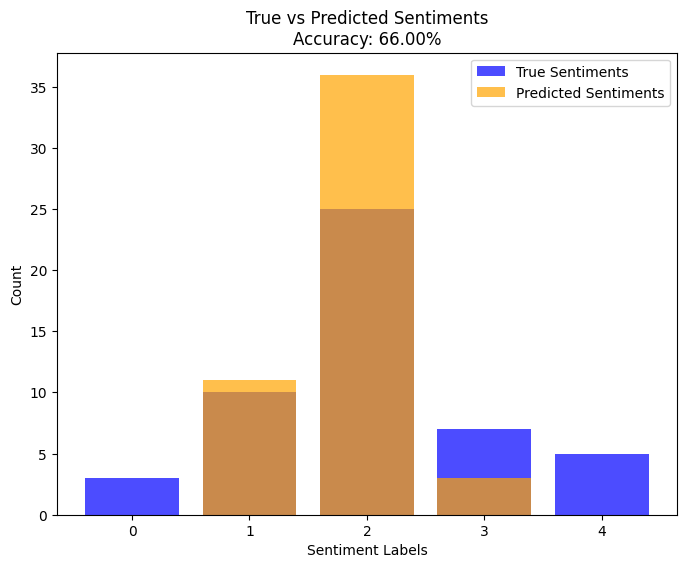

In [7]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import numpy as np

# use confusion matrix
conf_matrix = confusion_matrix(y_true_labels, predicted_class)

# accuracy
accuracy = accuracy_score(y_true_labels, predicted_class)

# Plot
fig, ax = plt.subplots(figsize=(8, 6))

ax.bar(np.arange(len(conf_matrix)), conf_matrix.sum(axis=1), color='blue', alpha=0.7, label='True Sentiments')

ax.bar(np.arange(len(conf_matrix)), conf_matrix.sum(axis=0), color='orange', alpha=0.7, label='Predicted Sentiments')

ax.set_xticks(np.arange(len(conf_matrix)))
ax.set_xticklabels([0, 1, 2, 3, 4])
ax.set_xlabel('Sentiment Labels')
ax.set_ylabel('Count')
ax.set_title(f'True vs Predicted Sentiments\nAccuracy: {accuracy * 100:.2f}%')
ax.legend()

plt.show()


Confusion matrices are used to evaluate performance of classification models, so that was what I used to evaluate the model. In the histogram, you can see that the accuracy of the model was 66% and it mostly predicted phrases to be neutral. It overpredicted 1 and 2 and underpredicted 0,3,and 4 with 0 and 4 receiving no predictions. The low accuracy was most likely caused by the dataset being shortened for the training. 